In [1]:
!pip install datasets

In [2]:

import os
import sys
import json
import random
from ast import literal_eval

import numpy as np
import torch

# -----------------------------------------------------------------------------

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def setup_logging(config):
    """ monotonous bookkeeping """
    work_dir = config.system.work_dir
    # create the work directory if it doesn't already exist
    os.makedirs(work_dir, exist_ok=True)
    # log the args (if any)
    with open(os.path.join(work_dir, 'args.txt'), 'w') as f:
        f.write(' '.join(sys.argv))
    # log the config itself
    with open(os.path.join(work_dir, 'config.json'), 'w') as f:
        f.write(json.dumps(config.to_dict(), indent=4))

class CfgNode:
    """ a lightweight configuration class inspired by yacs """
    # TODO: convert to subclass from a dict like in yacs?
    # TODO: implement freezing to prevent shooting of own foot
    # TODO: additional existence/override checks when reading/writing params?

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __str__(self):
        return self._str_helper(0)

    def _str_helper(self, indent):
        """ need to have a helper to support nested indentation for pretty printing """
        parts = []
        for k, v in self.__dict__.items():
            if isinstance(v, CfgNode):
                parts.append("%s:\n" % k)
                parts.append(v._str_helper(indent + 1))
            else:
                parts.append("%s: %s\n" % (k, v))
        parts = [' ' * (indent * 4) + p for p in parts]
        return "".join(parts)

    def to_dict(self):
        """ return a dict representation of the config """
        return { k: v.to_dict() if isinstance(v, CfgNode) else v for k, v in self.__dict__.items() }

    def merge_from_dict(self, d):
        self.__dict__.update(d)

    def merge_from_args(self, args):
        """
        update the configuration from a list of strings that is expected
        to come from the command line, i.e. sys.argv[1:].

        The arguments are expected to be in the form of `--arg=value`, and
        the arg can use . to denote nested sub-attributes. Example:

        --model.n_layer=10 --trainer.batch_size=32
        """
        for arg in args:

            keyval = arg.split('=')
            assert len(keyval) == 2, "expecting each override arg to be of form --arg=value, got %s" % arg
            key, val = keyval # unpack

            # first translate val into a python object
            try:
                val = literal_eval(val)
                """
                need some explanation here.
                - if val is simply a string, literal_eval will throw a ValueError
                - if val represents a thing (like an 3, 3.14, [1,2,3], False, None, etc.) it will get created
                """
            except ValueError:
                pass

            # find the appropriate object to insert the attribute into
            assert key[:2] == '--'
            key = key[2:] # strip the '--'
            keys = key.split('.')
            obj = self
            for k in keys[:-1]:
                obj = getattr(obj, k)
            leaf_key = keys[-1]

            # ensure that this attribute exists
            assert hasattr(obj, leaf_key), f"{key} is not an attribute that exists in the config"

            # overwrite the attribute
            print("command line overwriting config attribute %s with %s" % (key, val))
            setattr(obj, leaf_key, val)

"""
bpe is short for Byte Pair Encoder. It translates arbitrary utf-8 strings into
sequences of integers, where each integer represents small chunks of commonly
occuring characters. This implementation is based on openai's gpt2 encoder.py:
https://github.com/openai/gpt-2/blob/master/src/encoder.py
but was mildly modified because the original implementation is a bit confusing.
I also tried to add as many comments as possible, my own understanding of what's
going on.
"""

import os
import json
import regex as re
import requests

import torch

# -----------------------------------------------------------------------------

def bytes_to_unicode():
    """
    Every possible byte (really an integer 0..255) gets mapped by OpenAI to a unicode
    character that represents it visually. Some bytes have their appearance preserved
    because they don't cause any trouble. These are defined in list bs. For example:
    chr(33) returns "!", so in the returned dictionary we simply have d[33] -> "!".
    However, chr(0), for example, is '\x00', which looks ugly. So OpenAI maps these
    bytes, into new characters in a range where chr() returns a single nice character.
    So in the final dictionary we have d[0] -> 'Ā' instead, which is just chr(0 + 2**8).
    In particular, the space character is 32, which we can see by ord(' '). Instead,
    this function will shift space (32) by 256 to 288, so d[32] -> 'Ġ'.
    So this is just a simple one-to-one mapping of bytes 0..255 into unicode characters
    that "look nice", either in their original form, or a funny shifted character
    like 'Ā', or 'Ġ', etc.
    """
    # the 188 integers that render fine in their original form and need no shifting
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:] # all integers b in bs will simply map to chr(b) in the output dict
    # now get the representations of the other 68 integers that do need shifting
    # each will get mapped chr(256 + n), where n will grow from 0...67 in the loop
    n = 0
    for b in range(2**8):
        if b not in bs:
            # if this byte is "ugly" then map it to the next available "nice" character
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    d = dict(zip(bs, cs))
    return d

def get_pairs(word):
    """
    Return all bigrams as a set of tuples, of consecutive elements in the iterable word.
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

class Encoder:

    def __init__(self, encoder, bpe_merges):
        # byte encoder/decoder
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v:k for k, v in self.byte_encoder.items()}
        # bpe token encoder/decoder
        self.encoder = encoder
        self.decoder = {v:k for k,v in self.encoder.items()}
        # bpe merge list that defines the bpe "tree", of tuples (a,b) that are to merge to token ab
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        # the splitting pattern used for pre-tokenization
        # Should haved added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions <-- original openai comment
        """
        ok so what is this regex looking for, exactly?
        python re reference: https://docs.python.org/3/library/re.html
        - the vertical bars | is OR, so re.findall will chunkate text as the pieces match, from left to right
        - '\'s' would split up things like Andrej's -> (Andrej, 's)
        - ' ?\p{L}': optional space followed by 1+ unicode code points in the category "letter"
        - ' ?\p{N}': optional space followed by 1+ unicode code points in the category "number"
        - ' ?[^\s\p{L}\p{N}]+': optional space, then 1+ things that are NOT a whitespace, letter or number
        - '\s+(?!\S)': 1+ whitespace characters (e.g. space or tab or etc) UNLESS they are followed by non-whitespace
                       so this will consume whitespace characters in a sequence but exclude the last whitespace in
                       that sequence. that last whitespace has the opportunity to then match the optional ' ?' in
                       earlier patterns.
        - '\s+': 1+ whitespace characters, intended probably to catch a full trailing sequence of whitespaces at end of string
        So TLDR:
        - we are special casing a few common apostrophe constructs ('s, 't, 're, ...) and making those into separate tokens
        - we then separate out strings into consecutive chunks of 1) letters, 2) numbers, 3) non-letter-numbers, 4) whitespaces
        """
        self.pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
        self.cache = {}

    def bpe(self, token):
        """
        this function uses self.bpe_ranks to iteratively merge all the possible bpe tokens
        up the tree. token is a string of one individual 'word' (after regex tokenization)
        and after byte encoding, e.g. 'Ġthere'.
        """
        # token is a string of one individual 'word', after byte encoding, e.g. 'Ġthere'

        # memoization, for efficiency
        if token in self.cache:
            return self.cache[token]

        word = tuple(token) # individual characters that make up the token, in a tuple
        pairs = get_pairs(word) # get all bigrams

        if not pairs:
            return token

        while True:

            # find the next lowest rank bigram that can be merged
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break # no more bigrams are eligible to be merged
            first, second = bigram

            # we will now replace all occurences of (first, second) in the list of current
            # words into one merged token first_second, in the output list new_words
            new_word = []
            i = 0
            while i < len(word):

                # find the next occurence of first in the sequence of current words
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                # if this occurence is also followed by second, then merge them into one
                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1

            # all occurences of (first, second) have been merged to first_second
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)

        # concat all words into a string, and use ' ' as the separator. Note that
        # by now all characters have been byte encoded, guaranteeing that ' ' is
        # not used in the actual data and is a 'special' delimiter character
        word = ' '.join(word)

        # cache the result and return
        self.cache[token] = word
        return word

    def encode(self, text):
        """ string goes in, list of integers comes out """
        bpe_idx = []
        # pre-tokenize the input text into string tokens (words, roughly speaking)
        tokens = re.findall(self.pat, text)
        # process each token into BPE integers
        for token in tokens:
            # encode the token as a bytes (b'') object
            token_bytes = token.encode('utf-8')
            # translate all bytes to their unicode string representation and flatten
            token_translated = ''.join(self.byte_encoder[b] for b in token_bytes)
            # perform all the applicable bpe merges according to self.bpe_ranks
            token_merged = self.bpe(token_translated).split(' ')
            # translate all bpe tokens to integers
            token_ix = [self.encoder[bpe_token] for bpe_token in token_merged]
            # extend our running list of all output integers
            bpe_idx.extend(token_ix)
        return bpe_idx

    def encode_and_show_work(self, text):
        """ debugging function, same as encode but returns all intermediate work """
        bpe_idx = []
        parts = []
        tokens = re.findall(self.pat, text)
        for token in tokens:
            token_bytes = token.encode('utf-8')
            token_translated = ''.join(self.byte_encoder[b] for b in token_bytes)
            token_merged = self.bpe(token_translated).split(' ')
            token_ix = [self.encoder[bpe_token] for bpe_token in token_merged]
            bpe_idx.extend(token_ix)
            parts.append({
                'token': token,
                'token_bytes': token_bytes,
                'token_translated': token_translated,
                'token_merged': token_merged,
                'token_ix': token_ix,
            })
        out = {
            'bpe_idx': bpe_idx, # the actual output sequence
            'tokens': tokens, # result of pre-tokenization
            'parts': parts, # intermediates for each token part
        }
        return out

    def decode(self, bpe_idx):
        """ list of integers comes in, string comes out """
        # inverse map the integers to get the tokens
        tokens_merged = [self.decoder[token] for token in bpe_idx]
        # inverse the byte encoder, e.g. recovering 'Ġ' -> ' ', and get the bytes
        tokens_flat = ''.join(tokens_merged)
        tokens_bytes = bytearray([self.byte_decoder[c] for c in tokens_flat])
        # recover the full utf-8 string
        text = tokens_bytes.decode('utf-8', errors='replace')
        return text

def get_file(local_file, remote_file):
    """ downloads remote_file to local_file if necessary """
    if not os.path.isfile(local_file):
        print(f"downloading {remote_file} to {local_file}")
        response = requests.get(remote_file)
        open(local_file, "wb").write(response.content)

def get_encoder():
    """
    Returns an instance of the GPT BPE Encoder/Decoder
    and handles caching of "database" files.
    """
    home_dir = os.path.expanduser('~')
    cache_dir = os.path.join(home_dir, '.cache', 'mingpt')
    os.makedirs(cache_dir, exist_ok=True)

    # load encoder.json that has the raw mappings from token -> bpe index
    encoder_local_file = os.path.join(cache_dir, 'encoder.json')
    encoder_remote_file = 'https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json'
    get_file(encoder_local_file, encoder_remote_file)
    with open(encoder_local_file, 'r') as f:
        encoder = json.load(f)
    assert len(encoder) == 50257 # 256 individual byte tokens, 50,000 merged tokens, and 1 special <|endoftext|> token

    # load vocab.bpe that contains the bpe merges, i.e. the bpe tree structure
    # in the form tuples (a, b), that indicate that (a, b) is to be merged to one token ab
    vocab_local_file = os.path.join(cache_dir, 'vocab.bpe')
    vocab_remote_file = 'https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe'
    get_file(vocab_local_file, vocab_remote_file)
    with open(vocab_local_file, 'r', encoding="utf-8") as f:
        bpe_data = f.read()
    # light postprocessing: strip the version on first line and the last line is a blank
    bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
    assert len(bpe_merges) == 50000 # 50,000 merged tokens

    # construct the Encoder object and return
    enc = Encoder(encoder, bpe_merges)
    return enc

# -----------------------------------------------------------------------------

class BPETokenizer:
    """ PyTorch-aware class that wraps the Encoder above """

    def __init__(self):
        self.encoder = get_encoder()

    def __call__(self, text, return_tensors='pt'):
        # PyTorch only; here because we want to match huggingface/transformers interface
        assert return_tensors == 'pt'
        # single string input for now, in the future potentially a list of strings
        assert isinstance(text, str)
        # encode and create a "batch dimension" of 1
        idx = [self.encoder.encode(text)]
        # wrap into PyTorch tensor
        out = torch.tensor(idx, dtype=torch.long)
        return out

    def decode(self, idx):
        # ensure a simple 1D tensor for now
        assert idx.ndim == 1
        # decode indices to text
        text = self.encoder.decode(idx.tolist())
        return text


if __name__ == '__main__':

    # here is an encoding example
    text = "Hello!! I'm Andrej Karpathy. It's 2022. w00t :D 🤗"
    e = get_encoder()
    r = e.encode_and_show_work(text)

    print("Original text is:")
    print(text)
    print("First the text gets pre-tokenized, broken up into chunks, the outcome is:")
    print(r['tokens'])
    # ['Hello', '!!', ' I', "'m", ' Andrej', ' Karpathy', '.', ' It', "'s", ' 2022', '.', ' w', '00', 't', ' :', 'D', ' 🤗']
    print("Then we iterate over each chunk and process them in turn...")
    for part in r['parts']:
        print(part)
    # {'token': 'Hello', 'token_bytes': b'Hello', 'token_translated': 'Hello', 'token_merged': ['Hello'], 'token_ix': [15496]}
    # {'token': '!!', 'token_bytes': b'!!', 'token_translated': '!!', 'token_merged': ['!!'], 'token_ix': [3228]}
    # {'token': ' I', 'token_bytes': b' I', 'token_translated': 'ĠI', 'token_merged': ['ĠI'], 'token_ix': [314]}
    # {'token': "'m", 'token_bytes': b"'m", 'token_translated': "'m", 'token_merged': ["'m"], 'token_ix': [1101]}
    # {'token': ' Andrej', 'token_bytes': b' Andrej', 'token_translated': 'ĠAndrej', 'token_merged': ['ĠAndre', 'j'], 'token_ix': [10948, 73]}
    # {'token': ' Karpathy', 'token_bytes': b' Karpathy', 'token_translated': 'ĠKarpathy', 'token_merged': ['ĠK', 'arp', 'athy'], 'token_ix': [509, 5117, 10036]}
    # {'token': '.', 'token_bytes': b'.', 'token_translated': '.', 'token_merged': ['.'], 'token_ix': [13]}
    # {'token': ' It', 'token_bytes': b' It', 'token_translated': 'ĠIt', 'token_merged': ['ĠIt'], 'token_ix': [632]}
    # {'token': "'s", 'token_bytes': b"'s", 'token_translated': "'s", 'token_merged': ["'s"], 'token_ix': [338]}
    # {'token': ' 2022', 'token_bytes': b' 2022', 'token_translated': 'Ġ2022', 'token_merged': ['Ġ2022'], 'token_ix': [33160]}
    # {'token': '.', 'token_bytes': b'.', 'token_translated': '.', 'token_merged': ['.'], 'token_ix': [13]}
    # {'token': ' w', 'token_bytes': b' w', 'token_translated': 'Ġw', 'token_merged': ['Ġw'], 'token_ix': [266]}
    # {'token': '00', 'token_bytes': b'00', 'token_translated': '00', 'token_merged': ['00'], 'token_ix': [405]}
    # {'token': 't', 'token_bytes': b't', 'token_translated': 't', 'token_merged': ['t'], 'token_ix': [83]}
    # {'token': ' :', 'token_bytes': b' :', 'token_translated': 'Ġ:', 'token_merged': ['Ġ:'], 'token_ix': [1058]}
    # {'token': 'D', 'token_bytes': b'D', 'token_translated': 'D', 'token_merged': ['D'], 'token_ix': [35]}
    # {'token': ' 🤗', 'token_bytes': b' \xf0\x9f\xa4\x97', 'token_translated': 'ĠðŁ¤Ĺ', 'token_merged': ['ĠðŁ', '¤', 'Ĺ'], 'token_ix': [12520, 97, 245]}
    # (refer to the code inside Encoder.encode for what these intermediates are)
    print("and the final outcome is concatenating and flattening all the token_ix:")
    print(r['bpe_idx'])
    # [15496, 3228, 314, 1101, 10948, 73, 509, 5117, 10036, 13, 632, 338, 33160, 13, 266, 405, 83, 1058, 35, 12520, 97, 245]
    # this would then become the integer input sequence to the transformer
    print("ready to feed into a Transformer!")


import math

import torch
import torch.nn as nn
from torch.nn import functional as F

# from Utils import CfgNode as CN

# -----------------------------------------------------------------------------

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class GPT(nn.Module):
    """ GPT Language Model """

    @staticmethod
    def get_default_config():
        C = CfgNode()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size

        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                # names follow the huggingface naming conventions
                # GPT-1
                'openai-gpt':   dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                # GPT-2 configs
                'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
                'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
                'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
                # Gophers
                'gopher-44m':   dict(n_layer=8, n_head=16, n_embd=512),
                # (there are a number more...)
                # I made these tiny models up
                'gpt-mini':     dict(n_layer=6, n_head=6, n_embd=192),
                'gpt-micro':    dict(n_layer=4, n_head=4, n_embd=128),
                'gpt-nano':     dict(n_layer=3, n_head=3, n_embd=48),
            }[config.model_type])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        """
        Initialize a pretrained GPT model by copying over the weights
        from a huggingface/transformers checkpoint.
        """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel

        # create a from-scratch initialized minGPT model
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 50257 # openai's model vocabulary
        config.block_size = 1024  # openai's model block_size
        model = GPT(config)
        sd = model.state_dict()

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] # ignore these
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla nn.Linear.
        # this means that we have to transpose these weights when we import them
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import time
from collections import defaultdict

import torch
from torch.utils.data.dataloader import DataLoader
# from Utils import CfgNode as CN

class Trainer:

    @staticmethod
    def get_default_config():
        C = CfgNode()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 4
        # optimizer parameters
        C.max_iters = None
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1 # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.callbacks = defaultdict(list)

        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config

        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)

        # setup the dataloader
        train_loader = DataLoader(
            self.train_dataset,
            sampler=torch.utils.data.RandomSampler(self.train_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=True,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
        )

        model.train()
        self.iter_num = 0
        self.iter_time = time.time()
        data_iter = iter(train_loader)
        while True:

            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)
            batch = [t.to(self.device) for t in batch]
            x, y = batch

            # forward the model
            logits, self.loss = model(x, y)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()

            self.trigger_callbacks('on_batch_end')
            self.iter_num += 1
            tnow = time.time()
            self.iter_dt = tnow - self.iter_time
            self.iter_time = tnow

            # termination conditions
            if config.max_iters is not None and self.iter_num >= config.max_iters:
                break

<>:183: SyntaxWarning: invalid escape sequence '\p'
<>:183: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2610947628.py:183: SyntaxWarning: invalid escape sequence '\p'
  - ' ?\p{L}': optional space followed by 1+ unicode code points in the category "letter"


downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json to /root/.cache/mingpt/encoder.json
downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe to /root/.cache/mingpt/vocab.bpe
Original text is:
Hello!! I'm Andrej Karpathy. It's 2022. w00t :D 🤗
First the text gets pre-tokenized, broken up into chunks, the outcome is:
['Hello', '!!', ' I', "'m", ' Andrej', ' Karpathy', '.', ' It', "'s", ' 2022', '.', ' w', '00', 't', ' :', 'D', ' 🤗']
Then we iterate over each chunk and process them in turn...
{'token': 'Hello', 'token_bytes': b'Hello', 'token_translated': 'Hello', 'token_merged': ['Hello'], 'token_ix': [15496]}
{'token': '!!', 'token_bytes': b'!!', 'token_translated': '!!', 'token_merged': ['!!'], 'token_ix': [3228]}
{'token': ' I', 'token_bytes': b' I', 'token_translated': 'ĠI', 'token_merged': ['ĠI'], 'token_ix': [314]}
{'token': "'m", 'token_bytes': b"'m", 'token_translated': "'m", 'token_merged': ["'m"], 'token_ix': [1101]

In [3]:
# ============================================================
# TinyStories + BPETokenizer + minGPT (Fast Version)
# ============================================================

!pip install datasets --quiet
import time
import math
import matplotlib.pyplot as plt
from datasets import load_dataset

import torch
from torch.utils.data import Dataset

# ============================================================
# 1. Load TinyStories
# ============================================================

print("Loading TinyStories (20k samples)...")
tiny_raw = load_dataset("roneneldan/TinyStories", split="train[:20000]")
texts = [x["text"] for x in tiny_raw]
print("Loaded", len(texts), "stories.")


# ============================================================
# 2. Fast Dataset
# ============================================================

class TinyStoriesDataset(Dataset):
    def __init__(self, tokenizer, block_size, texts):
        self.block_size = block_size

        print("Tokenizing stories...")
        full_text = "\n".join(texts)

        ids = tokenizer(full_text)

        if isinstance(ids, torch.Tensor):
            ids = ids.view(-1)
        else:
            ids = torch.tensor(ids, dtype=torch.long)

        self.data = ids
        print("Total tokens:", len(self.data))

        self.num_samples = len(self.data) - block_size - 1
        print("Dataset size:", self.num_samples)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + 1 + self.block_size]
        return x, y


# ============================================================
# 3. Create Dataset + Model Config
# ============================================================

tokenizer = BPETokenizer()
block_size = 64
dataset = TinyStoriesDataset(tokenizer, block_size, texts)

config = GPT.get_default_config()
config.model_type = None
config.vocab_size = getattr(tokenizer, "vocab_size", 50257)
config.block_size = block_size

# Switch ALiBi ON/OFF here:
config.use_alibi = True

config.n_layer = 4
config.n_head = 4
config.n_embd = 128

model = GPT(config)


# ============================================================
# 4. Training Configuration
# ============================================================

trainer_cfg = Trainer.get_default_config()
trainer_cfg.device = "auto"
trainer_cfg.max_iters = 800
trainer_cfg.batch_size = 32
trainer_cfg.learning_rate = 3e-4

trainer = Trainer(trainer_cfg, model, dataset)


# ============================================================
# 5. Tracking Loss + Perplexity
# ============================================================

loss_history = []
ppl_history = []

def record_metrics(tr):
    loss = tr.loss.item()
    loss_history.append(loss)
    ppl_history.append(math.exp(loss))

trainer.add_callback("on_batch_end", record_metrics)


# ============================================================
# 6. Simple loss logger
# ============================================================

def print_loss(tr):
    if tr.iter_num % 20 == 0:
        print(f"iter {tr.iter_num:4d} | loss = {tr.loss.item():.4f}")

trainer.add_callback("on_batch_end", print_loss)


# ============================================================
# 7. Train!
# ============================================================

print("Starting training...")
t0 = time.time()
trainer.run()
t1 = time.time()
print(f"Done training. Total time: {t1 - t0:.2f} seconds")

Loading TinyStories (20k samples)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Loaded 20000 stories.
Tokenizing stories...
Total tokens: 4466060
Dataset size: 4465995
number of parameters: 7.23M
running on device cuda
Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


iter    0 | loss = 10.8355
iter   20 | loss = 9.5361
iter   40 | loss = 8.3647
iter   60 | loss = 7.3289
iter   80 | loss = 6.7000
iter  100 | loss = 6.1734
iter  120 | loss = 5.7794
iter  140 | loss = 5.6347
iter  160 | loss = 5.3330
iter  180 | loss = 5.0962
iter  200 | loss = 4.8549
iter  220 | loss = 4.8116
iter  240 | loss = 4.7118
iter  260 | loss = 4.6223
iter  280 | loss = 4.5346
iter  300 | loss = 4.2881
iter  320 | loss = 4.3518
iter  340 | loss = 4.3560
iter  360 | loss = 4.2800
iter  380 | loss = 4.1750
iter  400 | loss = 4.4115
iter  420 | loss = 4.1186
iter  440 | loss = 4.1201
iter  460 | loss = 3.9756
iter  480 | loss = 3.8488
iter  500 | loss = 4.0493
iter  520 | loss = 3.8512
iter  540 | loss = 4.1302
iter  560 | loss = 3.9001
iter  580 | loss = 3.6887
iter  600 | loss = 3.8103
iter  620 | loss = 3.9265
iter  640 | loss = 3.9209
iter  660 | loss = 3.9140
iter  680 | loss = 3.6953
iter  700 | loss = 3.7882
iter  720 | loss = 3.8454
iter  740 | loss = 3.7885
iter  760 |

In [4]:
model.eval()

prompt = "Ian was"

# get device the proper way
device = next(model.parameters()).device

idx = tokenizer(prompt).to(device)

generated = model.generate(
    idx,
    max_new_tokens=150,
    temperature=0.9,
    do_sample=True,
    top_k=50
)

print(tokenizer.decode(generated[0]))


Ian was excited. Tim was sad and he flew on her name. . She didn't have a small girl, but he was so proud to pick. She said, "Can your car that you can we have to play with it. She told me?"

Soon, She was happy in Lily and her, "I feel scared. Do you can make a new dress. They are you to share the dog. And the man's mom.

"Hello, but the park. He is glad I'm sorry for him. You are it has a big hill.â€

"Wow, then, Ben, it is a good friend. Can we will hurt the ball in the forest. He thought for the sun is so


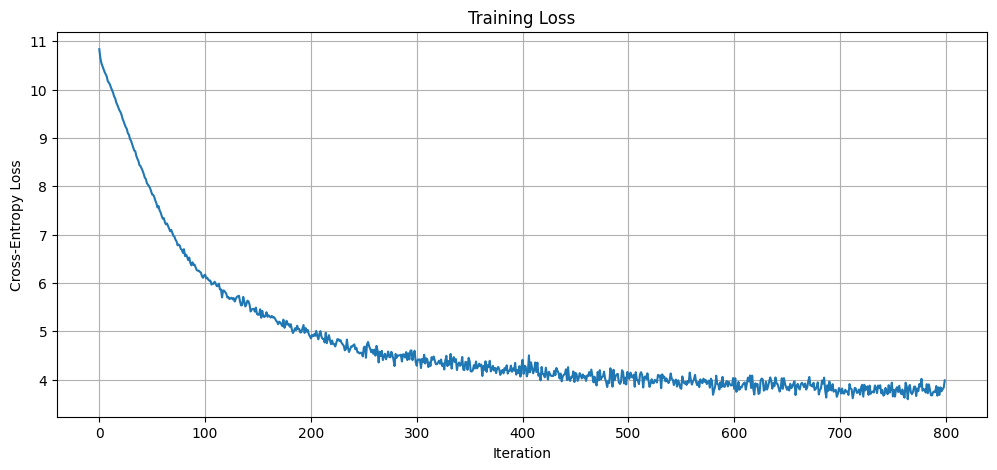

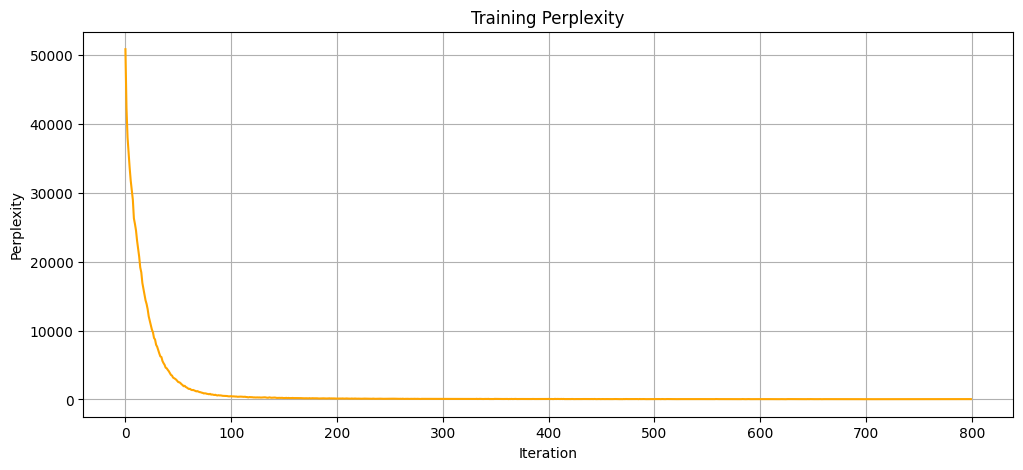

In [5]:
# ============================================================
# 8. Plot Loss + Perplexity
# ============================================================

plt.figure(figsize=(12,5))
plt.plot(loss_history, label="Loss")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(ppl_history, label="Perplexity", color="orange")
plt.title("Training Perplexity")
plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()